In [2]:

import pandas as pd
import numpy as np
from unidecode import unidecode
from libpysal.weights.contiguity import Queen
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#df_f0=pd.read_excel("Bases//Base_Limpia.xlsx")

from scipy.stats import pearsonr, chi2_contingency

df_f0=pd.read_csv("Bases//Base_Limpia_Added.csv")

df_f=df_f0.copy()


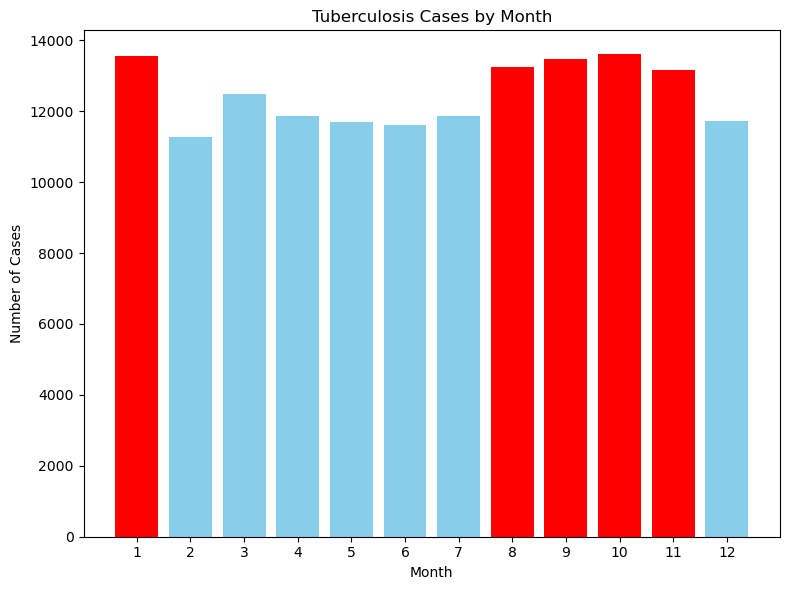

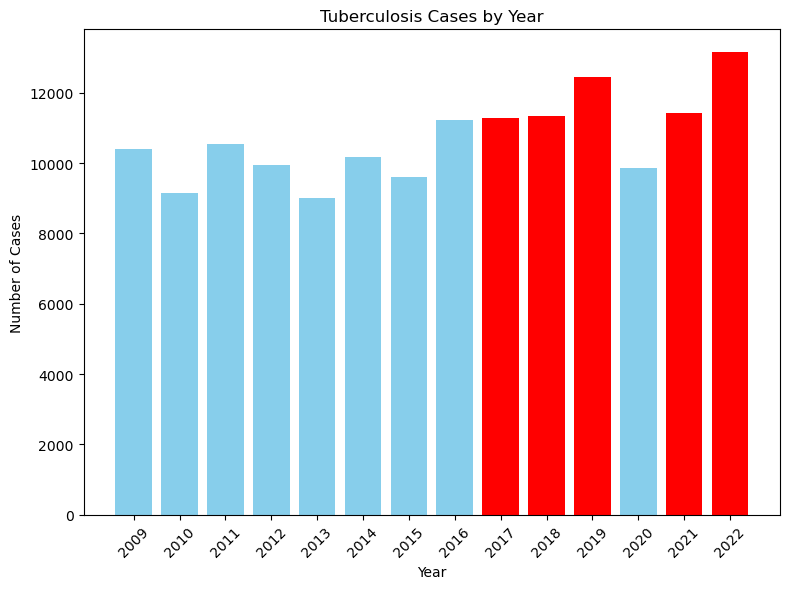

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_f0 is your DataFrame and the following preprocessing has been done:
df_f0['fecha'] = pd.to_datetime(df_f0['fecha'])
df_f0['fnyear'] = df_f0['fecha'].dt.year
df_f0['fnmonth'] = df_f0['fecha'].dt.month

# Filter out the years 2009 and 2022
df_filtered = df_f0[(df_f0['fnyear'] != 2006) & (df_f0['fnyear'] != 2023)]

# Group by year and count cases
cases_by_year = df_filtered.groupby('fnyear').size()

# Get the top 5 years with the highest number of cases
top_5_years = cases_by_year.nlargest(5)

# Group by month and count cases
cases_by_month = df_filtered.groupby('fnmonth').size()

# Get the top 5 months with the highest number of cases
top_5_months = cases_by_month.nlargest(5)

# Plotting tuberculosis cases by month
plt.figure(figsize=(8, 6))
colors_month = ['red' if month in top_5_months.index else 'skyblue' for month in cases_by_month.index]
plt.bar(cases_by_month.index, cases_by_month.values, color=colors_month)
plt.title('Tuberculosis Cases by Month')
plt.xlabel('Month')
plt.ylabel('Number of Cases')
plt.xticks(cases_by_month.index)
plt.tight_layout()
plt.savefig('Documentacion\\figures\\cases_by_month.png', dpi=300)  # Save the plot as PNG
plt.show()

# Plotting tuberculosis cases by year
plt.figure(figsize=(8, 6))
colors_year = ['red' if year in top_5_years.index else 'skyblue' for year in cases_by_year.index]
plt.bar(cases_by_year.index, cases_by_year.values, color=colors_year)
plt.title('Tuberculosis Cases by Year')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.xticks(cases_by_year.index, rotation=45)
plt.tight_layout()
plt.savefig('Documentacion\\figures\\cases_by_year.png', dpi=300)  # Save the plot as PNG
plt.show()



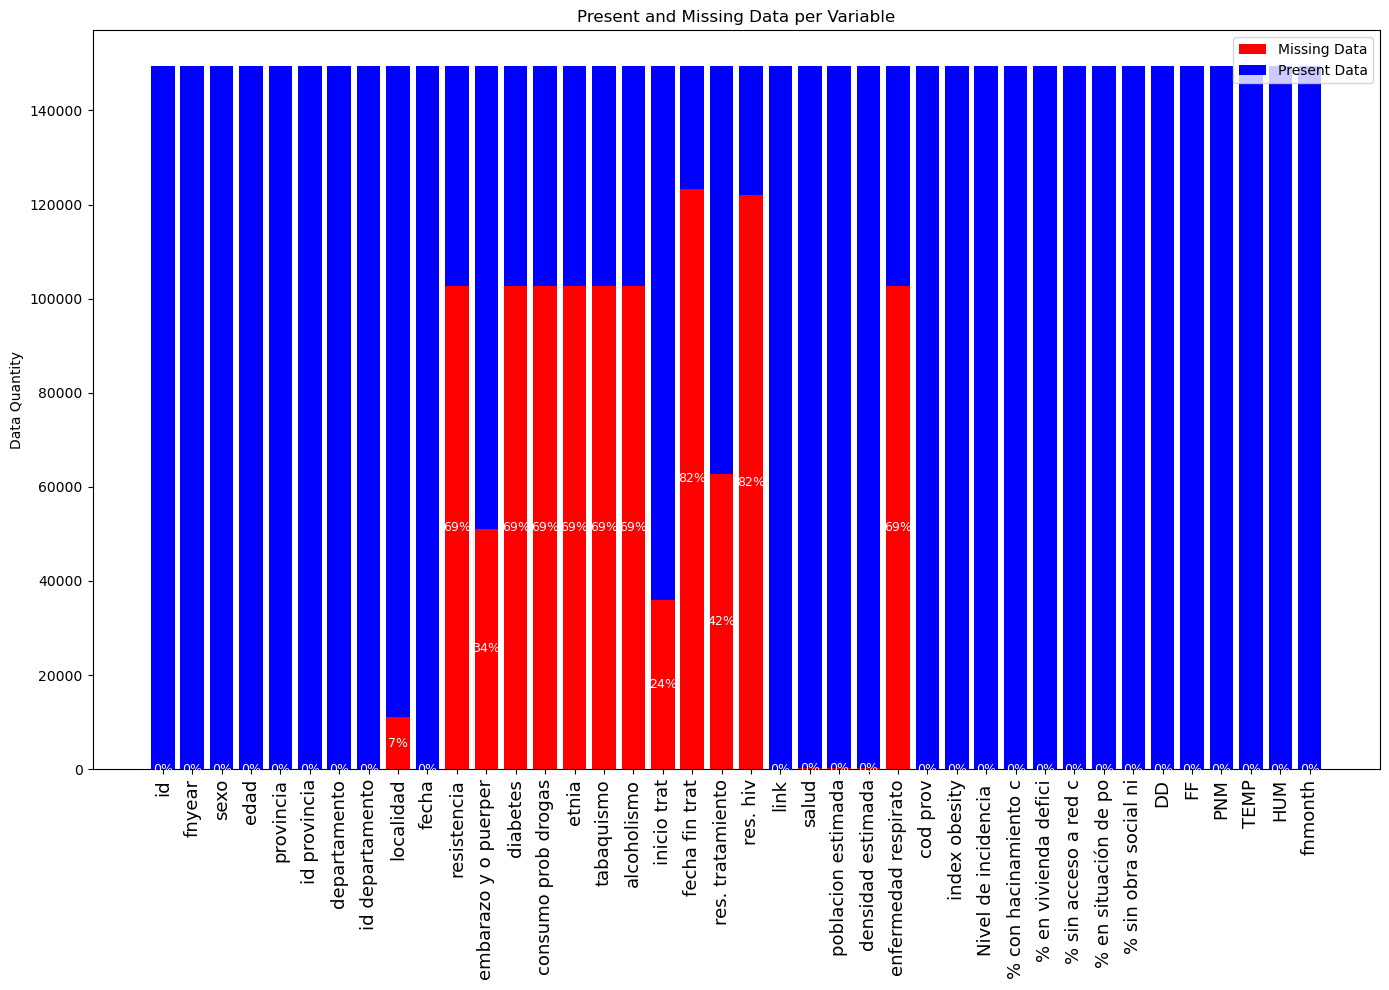

In [4]:



df_f_0_f = df_f0.copy()
df_f_0_f.replace('Sin Información', np.nan, inplace=True)

l_columns=df_f_0_f.columns
l_predictos2=[]
for s in l_columns:
    

    l_predictos2.append(s.replace("_"," ").replace(" crónica","").replace(" de hogares","").replace(" de población","").replace("resultado","res.")[:20])




df_f_0_f.columns=l_predictos2
# Create DataFrame for missing data
df_missing = pd.DataFrame(df_f_0_f.isnull().sum(), columns=["Missing Data #"])
df_missing["% Missing"] = round(df_missing["Missing Data #"] / len(df_f_0_f) * 100, 2)

# Create bar chart
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust chart size

# Get variables and values
variables = df_missing.index
values = df_missing["Missing Data #"]
percentages = df_missing["% Missing"]

# Blue bars for present data
blue_bar = ax.bar(variables, values, color='red', label='Missing Data')

# Red bars for missing data
red_bar = ax.bar(variables, len(df_f_0_f) - values, bottom=values, color='blue', label='Present Data')

# Percentage labels for missing data
for i, (percentage, value) in enumerate(zip(percentages, values)):
    ax.text(i, value / 2, f"{percentage:.0f}%", ha='center', va='center', color='white', fontsize=9)  # Change color to white

# Chart configuration
ax.set_ylabel('Data Quantity')
ax.set_title('Present and Missing Data per Variable')
ax.legend()

# Display chart
plt.xticks(rotation=90, fontsize=13)  # Ajusta el tamaño aquí

plt.tight_layout()
plt.savefig('Documentacion\\figures\\missing_data_chart.png', dpi=300)  # Higher resolution
plt.show()



In [5]:
# Calculate the minimum date in the dataset
min_fecha = pd.to_datetime(df_f['fecha']).min()

# Calculate the week number for each record
df_f['NUMERO_SEMANA'] = ((pd.to_datetime(df_f['fecha']) - min_fecha).dt.days // 7) + 1

# Create a pivot table to count the number of cases per week per province
df_aux2 = df_f.copy()
df_aux2 = pd.pivot_table(df_aux2, index=["provincia", "NUMERO_SEMANA"], values=["fecha"], aggfunc="count")

# Convert the pivot table to a DataFrame
df_aux3 = pd.DataFrame(df_aux2.to_records())
df_aux3.columns = ["provincia", "NUMERO_SEMANA", "CANTIDAD_CASOS"]

# Filter out rows where the province is "Desconocida"
df_aux3 = df_aux3.loc[df_aux3["provincia"] != "Desconocida"]

# Merge with the estimated population data and drop duplicates
df_aux2 = pd.merge(df_aux3, df_f[["provincia", "poblacion_estimada"]].drop_duplicates(), on="provincia", how="left").drop_duplicates(subset=["provincia", "NUMERO_SEMANA"], keep="first")

# Calculate the number of cases per inhabitant
df_aux2["N_CASOS_HAB"] = df_aux2["CANTIDAD_CASOS"] / df_aux2["poblacion_estimada"]

# Calculate the smoothed number of cases per inhabitant using a rolling mean
df_aux2["N_CASOS_HAB_SUAV"] = df_aux2.groupby('provincia')["N_CASOS_HAB"].rolling(window=52, min_periods=1).mean().reset_index(0, drop=True)


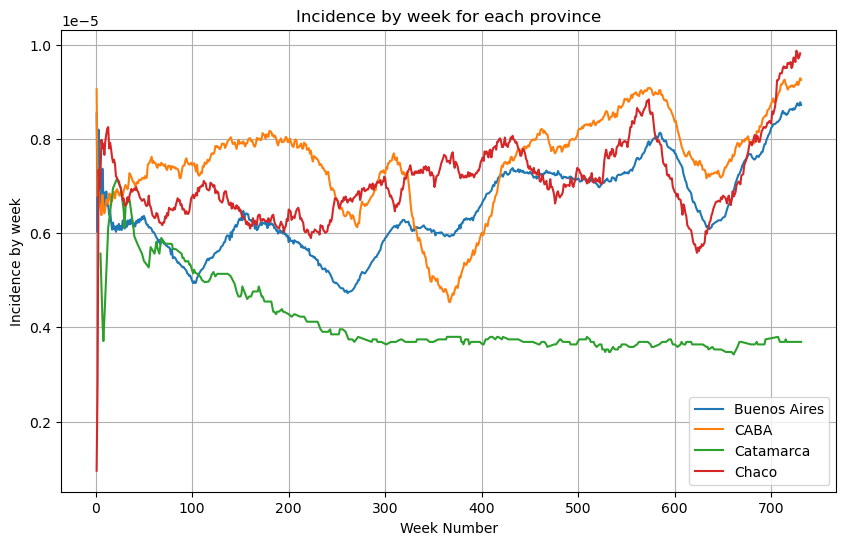

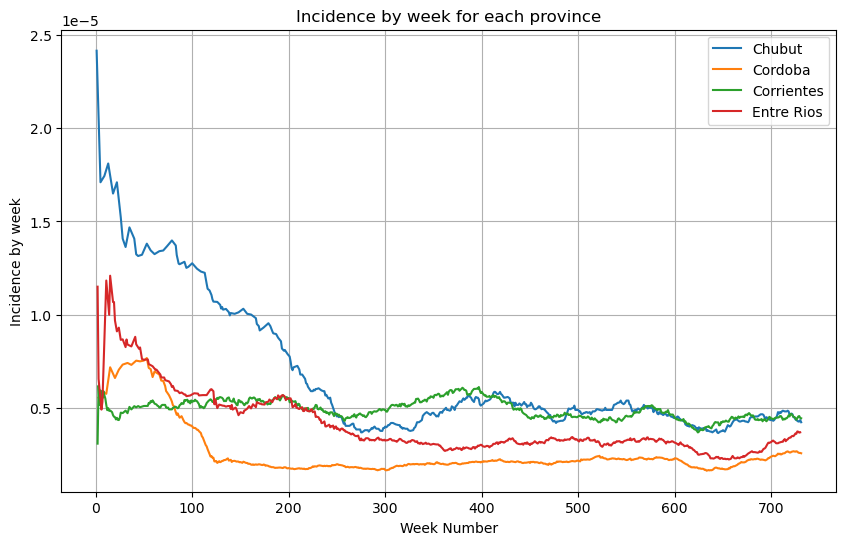

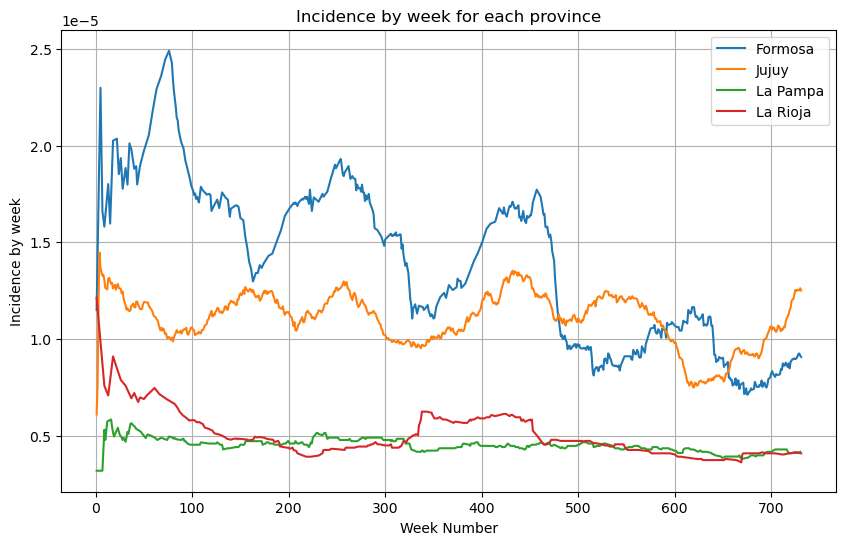

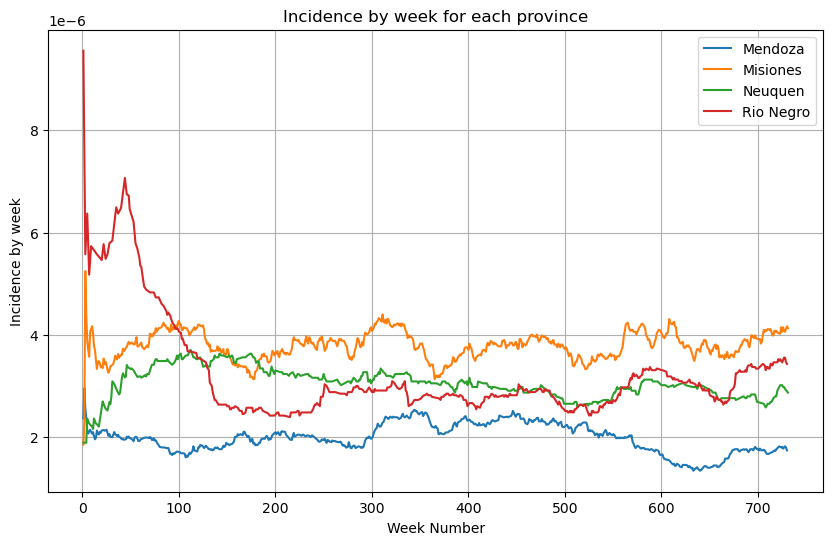

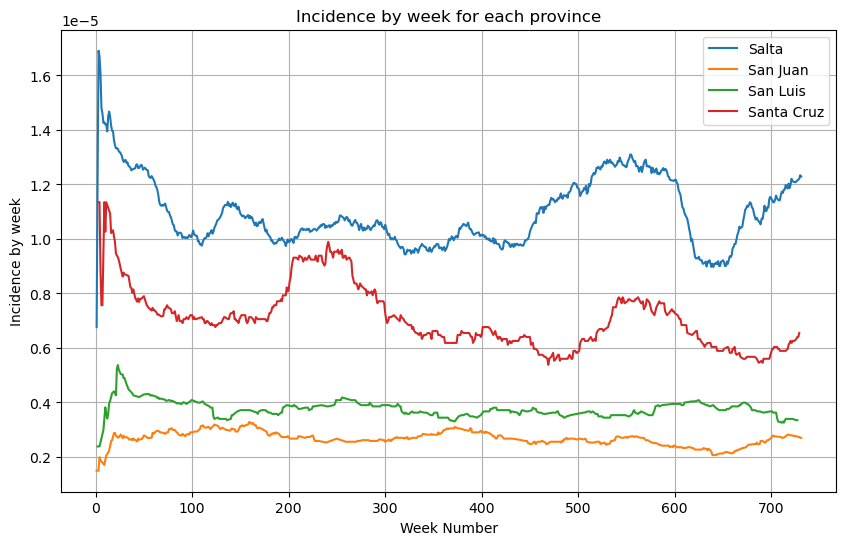

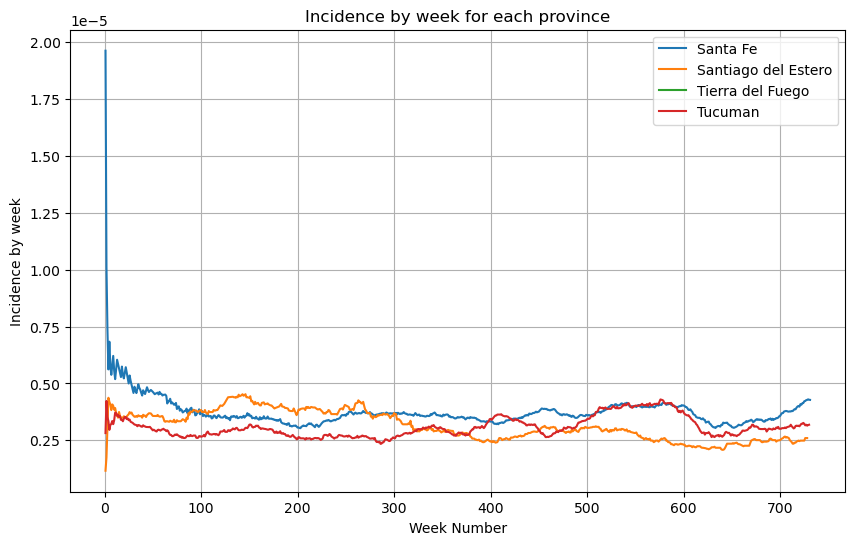

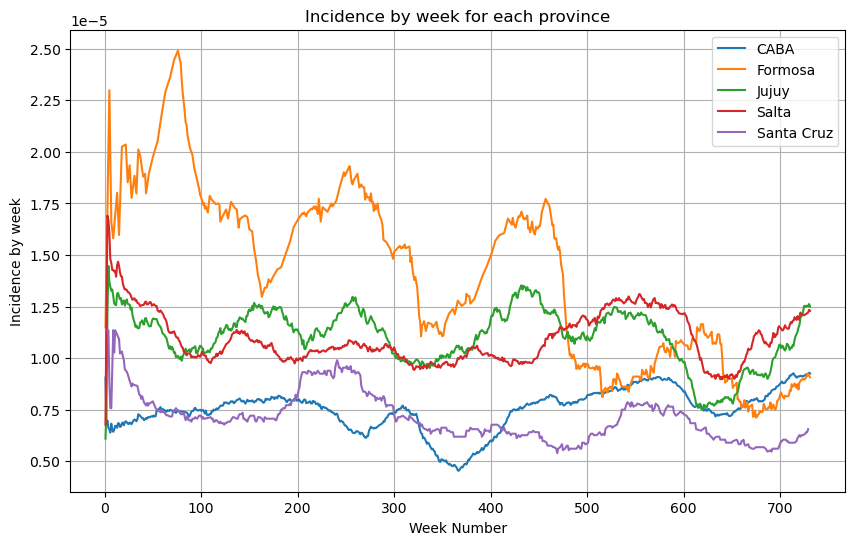

In [12]:
def plotear_provincia(df_aux2,save=False):
    """
    Plots the smoothed number of cases per inhabitant for each province over time.

    Args:
    df_aux2 (pd.DataFrame): DataFrame containing the data to be plotted.
    """
    plt.figure(figsize=(10, 6))

    provincias = df_aux2['provincia'].unique()
    for provincia in provincias:
        provincia_df = df_aux2[df_aux2['provincia'] == provincia]
        plt.plot(provincia_df['NUMERO_SEMANA'], provincia_df["N_CASOS_HAB_SUAV"], label=provincia)

    plt.xlabel('Week Number')
    plt.ylabel('Incidence by week')
    plt.title('Incidence by week for each province')
    plt.legend()
    plt.grid(True)
    if save==True:
        plt.savefig('Documentacion\\figures\\top_provinces.png', dpi=300)  # Higher resolution
    plt.show()

# List of unique provinces
l_provincias = list(df_aux2['provincia'].unique())

# Plot the data in batches of 4 provinces at a time
i = 0
while i < len(l_provincias):
    lista = l_provincias[i:i+4]
    i += 4
    df_aux3 = df_aux2.loc[df_aux2['provincia'].isin(lista)]
    plotear_provincia(df_aux3)

# Calculate the average smoothed number of cases per inhabitant by province
promedio_suavizado_por_provincia = df_aux2.groupby('provincia')["N_CASOS_HAB_SUAV"].mean()

# Get the top 5 provinces with the highest average smoothed number of cases
top_10_provincias = promedio_suavizado_por_provincia.nlargest(5).index

# Filter the data for the top 5 provinces and plot
df_top_10 = df_aux2[df_aux2['provincia'].isin(top_10_provincias)]
plotear_provincia(df_top_10,save=True)


In [7]:
import geopandas as gpd
from utils import utils

# Load shapefile data
ruta_archivo_shp = 'Bases\\Vecindad\\Codgeo_Pais_x_dpto_con_datos\\pxdptodatosok.shp'
dataframe_shp = gpd.read_file(ruta_archivo_shp)

# Create a pivot table with counts of each sex by province and department
df_sexo = pd.DataFrame(pd.pivot_table(df_f, index=["provincia", "departamento"], columns=["sexo"], aggfunc="size").to_records())
df_sexo.columns = ["provincia", "departamen", "F", "M"]

# Merge shapefile data with sex data
dataframe_shp2 = dataframe_shp[["departamen", "provincia", "mujeres", "varones"]]
df_sexo_total = pd.merge(dataframe_shp2, df_sexo, on=["provincia", "departamen"], how="left").fillna(0)

# Convert columns to integer type
df_sexo_total["mujeres"] = df_sexo_total["mujeres"].astype(int)
df_sexo_total["varones"] = df_sexo_total["varones"].astype(int)

# Calculate the total sum for each column
suma_por_columna = df_sexo_total.iloc[:, 2:].sum()

# Create a new row with the total sum
nueva_fila = {'provincia': 'Total', 'departamento': 'Total'}
for columna, suma in suma_por_columna.items():
    nueva_fila[columna] = suma

nueva_fila_df = pd.DataFrame([nueva_fila])

# Concatenate the total row to the DataFrame
df_sexo_total2 = pd.concat([df_sexo_total, nueva_fila_df], ignore_index=True)

# Calculate the percentage of males
df_sexo_total2["% varones"] = df_sexo_total2["varones"] / (df_sexo_total2["mujeres"] + df_sexo_total2["varones"])
df_sexo_total2["% M"] = df_sexo_total2["M"] / (df_sexo_total2["F"] + df_sexo_total2["M"])

# Filter the DataFrame for CABA
df_sexo_prov = df_sexo_total2.loc[df_sexo_total2["provincia"] == "Caba"]
df_sexo_prov = df_sexo_total2.loc[~df_sexo_total2["provincia"].isnull()]


In [8]:
import numpy as np
from scipy.stats import norm

# Data
total_women = df_sexo_prov["mujeres"].sum()
total_men = df_sexo_prov["varones"].sum()
infected_women = df_sexo_prov["F"].sum()
infected_men = df_sexo_prov["M"].sum()

# Calculate proportions of infected individuals
proportion_infected_women = infected_women / total_women
proportion_infected_men = infected_men / total_men

# Calculate standard errors of the proportions
se_women = np.sqrt(proportion_infected_women * (1 - proportion_infected_women) / total_women)
se_men = np.sqrt(proportion_infected_men * (1 - proportion_infected_men) / total_men)

# Calculate the difference in proportions
difference_proportions = proportion_infected_men - proportion_infected_women

# Calculate the 95% confidence interval for the difference in proportions
se_difference = np.sqrt(se_women**2 + se_men**2)
z_score = norm.ppf(0.975)  # Z-score for a 95% confidence interval
confidence_interval = z_score * se_difference

# Perform hypothesis testing
p_value = norm.cdf(-abs(difference_proportions) / se_difference) * 2

# Print results
print("Proportion of infected women:", proportion_infected_women)
print("Proportion of infected men:", proportion_infected_men)
print("Difference in proportions:", difference_proportions)
print("Standard error of the difference:", se_difference)
print("95% confidence interval:", (-confidence_interval, confidence_interval))
print("P-value:", p_value)

# Interpretation of the result
if p_value < 0.05:
    print("The difference in infection rates between men and women is statistically significant.")
else:
    print("There is no significant difference in infection rates between men and women.")


Proportion of infected women: 0.0005965523788527645
Proportion of infected men: 0.0008229969566322399
Difference in proportions: 0.00022644457777947543
Standard error of the difference: 5.961118021852662e-06
95% confidence interval: (-1.1683576630423868e-05, 1.1683576630423868e-05)
P-value: 0.0
The difference in infection rates between men and women is statistically significant.


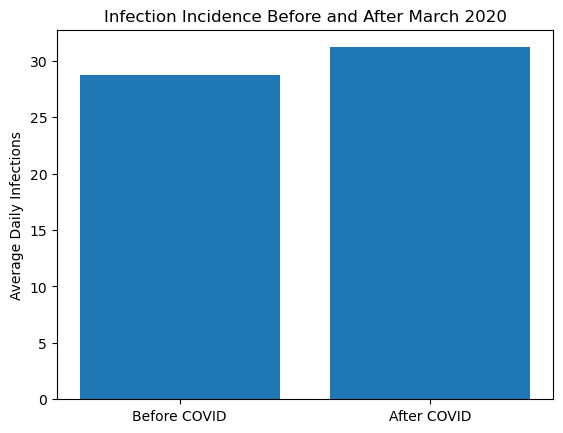

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df_f["fecha"] = pd.to_datetime(df_f["fecha"])

# Group infections by date and calculate the total number of infections for each date
conteo_infecciones = df_f.groupby("fecha").size()
rango_fechas = pd.date_range(start=conteo_infecciones.index.min(), end=conteo_infecciones.index.max(), freq='D')

# Create a DataFrame with the date range as index and the count of infections
datos_infecciones = pd.DataFrame({"fecha": conteo_infecciones}, index=rango_fechas)
datos_infecciones.fillna(0, inplace=True)
datos_infecciones.rename(columns={"fecha": 'infecciones'}, inplace=True)

# Split data into before and after March 2020
datos_antes_covid = datos_infecciones.loc[datos_infecciones.index < '2020-03-01']
datos_despues_covid = datos_infecciones.loc[datos_infecciones.index >= '2020-03-01']

# Calculate the average daily incidence of infections before and after March 2020
incidencia_antes_covid = datos_antes_covid['infecciones'].sum() / len(datos_antes_covid)
incidencia_despues_covid = datos_despues_covid['infecciones'].sum() / len(datos_despues_covid)

# Plotting
plt.bar(['Before COVID', 'After COVID'], [incidencia_antes_covid, incidencia_despues_covid])
plt.ylabel('Average Daily Infections')
plt.title('Infection Incidence Before and After March 2020')
plt.show()
